In [10]:
import os
import torch  # PyTorch
from monai.losses import DiceLoss  # MONAI loss function
from monai.optimizers import Novograd  # MONAI optimizer
from monai.networks.nets import UNet  # MONAI UNet model
from monai.transforms import (
    Compose,
    LoadImage,
    EnsureChannelFirst,
    ScaleIntensity,
    Resize,
    ToTensor,
    Lambda,
)
from monai.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Define paths
data_dir = "archive/ultrasound breast classification/train"  # Update this path
benign_dir = os.path.join(data_dir, "benign")
malignant_dir = os.path.join(data_dir, "malignant")

# Define transformations


def rgb_to_grayscale(image):
    if image.shape[0] == 3:  # If it's an RGB image
        return torch.mean(image, dim=0, keepdim=True)
    return image  # If it's already grayscale, return as is


def create_label_mask(label, shape):
    # Create a one-hot encoded mask
    mask = torch.zeros((2, shape[0], shape[1]))
    mask[label, :, :] = 1
    return mask


# Define image-only transformations
image_transforms = Compose(
    [
        LoadImage(image_only=True),
        EnsureChannelFirst(),
        ScaleIntensity(),
        Resize((224, 224)),
        Lambda(rgb_to_grayscale),
        ToTensor(),
    ]
)

# Define the full transform that applies image transforms only to 'img' key
transform = Compose(
    [
        Lambda(
            lambda x: {
                "img": image_transforms(x["img"]),
                "label": create_label_mask(x["label"], (224, 224)),
            }
        )
    ]
)
# Prepare the dataset
images = []
labels = []

# Load benign images
for filename in os.listdir(benign_dir):
    if filename.endswith((".png", ".jpg", ".jpeg")):  # Add more formats if needed
        images.append(os.path.join(benign_dir, filename))
        labels.append(0)  # Label 0 for benign

# Load malignant images
for filename in os.listdir(malignant_dir):
    if filename.endswith((".png", ".jpg", ".jpeg")):  # Add more formats if needed
        images.append(os.path.join(malignant_dir, filename))
        labels.append(1)  # Label 1 for malignant

# Create a dataset
dataset = Dataset(
    data=[{"img": img, "label": label} for img, label in zip(images, labels)],
    transform=transform,
)

# Create a DataLoader
batch_size = 64  # Define your batch size
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for batch_data in data_loader:
    # images, labels = batch_data['img'].to(device), batch_data['label'].to(device)
    print(batch_data["img"][0].shape)
    break

torch.Size([1, 224, 224])


In [2]:
model = UNet(
    spatial_dims=2,  # Change to 3 if you have 3D data
    in_channels=1,  # Change according to your data
    out_channels=2,  # Change according to your number of classes
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_function = DiceLoss(sigmoid=True)
optimizer = Novograd(model.parameters(), lr=1e-4)

# Define the number of epochs
num_epochs = 10  # You can change this to any number you prefer

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_data in data_loader:
        images, labels = batch_data['img'].to(device), batch_data['label'].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(data_loader)}")

Epoch 1/10, Loss: 0.6438752079711241
Epoch 2/10, Loss: 0.6197272562513164
Epoch 3/10, Loss: 0.5953194265272103
Epoch 4/10, Loss: 0.5734362771698073
Epoch 5/10, Loss: 0.555032398186478
Epoch 6/10, Loss: 0.5402045407715965
Epoch 7/10, Loss: 0.5286579856685564
Epoch 8/10, Loss: 0.5199942588806152
Epoch 9/10, Loss: 0.5136813305172265
Epoch 10/10, Loss: 0.5092051449943992


In [3]:
torch.save(model.state_dict(), 'unet_model.pth')
print("Model saved successfully.")

Model saved successfully.


In [4]:
def inference(model, input_data, device):
    model.eval()
    with torch.no_grad():
        input_data = input_data.to(device)
        output = model(input_data)
        # Apply sigmoid to get probability map
        output = torch.sigmoid(output)
        # Convert to binary mask (you can adjust the threshold)
        prediction = (output > 0.5).float()
    return prediction

# Example usage:
# Load the saved model
loaded_model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
)
loaded_model.load_state_dict(torch.load('unet_model.pth'))
loaded_model.to(device)

# Perform inference on a single image
sample_image = next(iter(data_loader))['img']  # Assuming data_loader is defined
prediction = inference(loaded_model, sample_image, device)

# You can now use the prediction for further processing or visualization

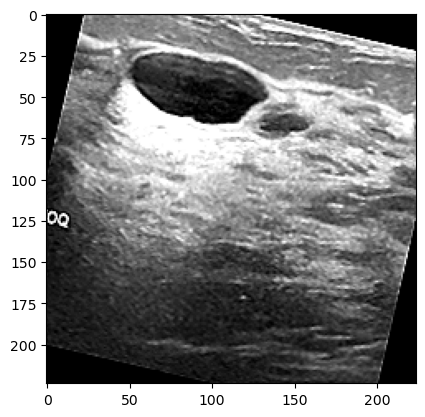

In [50]:
from PIL import Image

image_path = "archive/ultrasound breast classification/val/benign/benign (34)-rotated2-sharpened.png"
image = Image.open(image_path)
plt.imshow(image)

plt.show()

In [51]:
sample_image = image_transforms(image_path).unsqueeze(0)
sample_image.shape

torch.Size([1, 1, 224, 224])

In [52]:
with torch.no_grad():
    input_tensor = sample_image.to(device)
    output = model(input_tensor)
    # Apply softmax to get probability map
    output = torch.softmax(output, dim=1)
    # Get the predicted class (channel with highest probability)
    prediction = torch.argmax(output, dim=1)


result = prediction.squeeze().cpu().numpy()

In [53]:
result.shape

(224, 224)

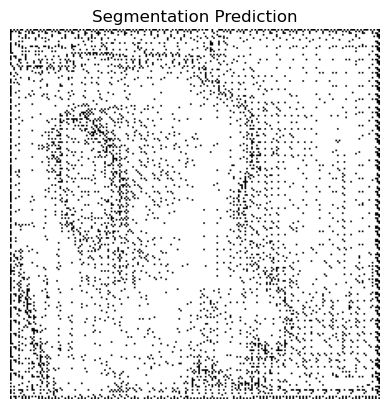

In [54]:
import matplotlib.pyplot as plt

plt.imshow(result, cmap='gray')
plt.title('Segmentation Prediction')
plt.axis('off')
plt.show()

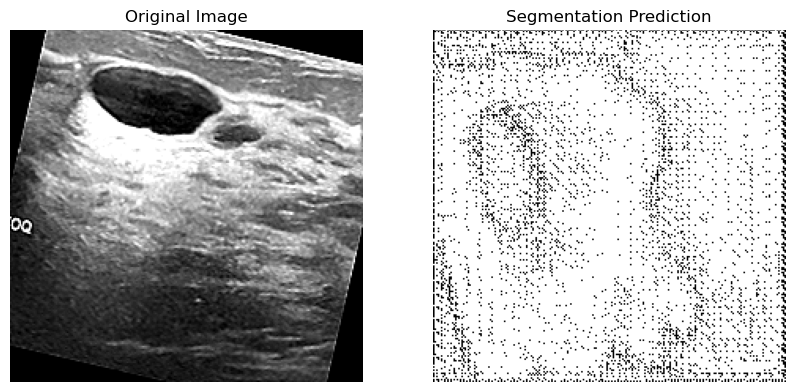

In [55]:
# Load the original image for comparison
original_image = Image.open(image_path).convert('L')
original_image = original_image.resize((224, 224))

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot original image
ax1.imshow(original_image, cmap='gray')
ax1.set_title('Original Image')
ax1.axis('off')

# Plot prediction
ax2.imshow(result, cmap='gray')
ax2.set_title('Segmentation Prediction')
ax2.axis('off')

plt.show()